In [1]:
%pylab inline
import warnings 
warnings.filterwarnings('ignore') # ワーニング を表示させない。

Populating the interactive namespace from numpy and matplotlib


In [2]:
# 価格情報を読込みます。
from sysdata.csvdata import csvFuturesData
data = csvFuturesData()

# インスツルメントの一覧
data=csvFuturesData()
", ".join(data.get_instrument_list())

'CORN, LEANHOG, LIVECOW, SOYBEAN, WHEAT, KR10, KR3, BOBL, BTP, BUND, OAT, SHATZ, US10, US2, US20, US5, V2X, VIX, KOSPI, AEX, CAC, SMI, NASDAQ, SP500, AUD, EUR, GBP, JPY, MXP, NZD, COPPER, GOLD, PALLAD, PLAT, CRUDE_W, GAS_US, EDOLLAR, EUROSTX'

In [3]:
# 定義済みのトレードルール EMAクロスを使用します。

from systems.provided.example.rules import ewmac_forecast_with_defaults as ewmac
from systems.forecasting import Rules

# ルールを作成するには幾つかの方法があります。

# そのまま、ewmac ルールを渡す方法
my_rules = Rules(ewmac)
print(my_rules.trading_rules())


# キーを付けて辞書型で渡すことも出来ます
my_rules = Rules(dict(ewmac=ewmac))
print(my_rules.trading_rules())

# キーを指定しない場合はデフォルトのキー（ rule0 ）が使用されます。
# ルールは TradingRuleオブジェクトとして保存されます。TradingRuleオブジェクトは次の３つの属性を持っています。
# ・function 
# ・function が必要とするデータ 
# ・function が必要とする引数 


{'rule0': TradingRule; function: <function ewmac_forecast_with_defaults at 0x7fdbf97b3b70>, data:  and other_args: }
{'ewmac': TradingRule; function: <function ewmac_forecast_with_defaults at 0x7fdbf97b3b70>, data:  and other_args: }


In [4]:
# 今度は先程のルールを使ってシステムを構成します。
from systems.basesystem import System
my_system = System([my_rules], data)

# EMA交差の予測値です。
print(my_system.rules.get_raw_forecast("EDOLLAR", "ewmac").tail(5))

2016-07-04    3.704434
2016-07-05    3.879053
2016-07-06    4.081771
2016-07-07    4.277728
2016-07-08    4.493940
Freq: B, dtype: float64


In [5]:
# ルールにパラメーターを渡すには TradingRule オブジェクトを使います。
from systems.forecasting import TradingRule

# パラメータはタプルや辞書型を使って渡します。
ewmac_8 = TradingRule((ewmac, [], dict(Lfast=8, Lslow=32))) # タプル
ewmac_32 = TradingRule(dict(function=ewmac, other_args=dict(Lfast=32, Lslow=128))) # 辞書型

# ２つのルールを使ったシステムを作ります。
my_rules = Rules(dict(ewmac8=ewmac_8, ewmac32=ewmac_32))
print(my_rules.trading_rules()['ewmac32'])

# このルールの予測値を出力するにはこうします。
my_system = System([my_rules], data)
my_system.rules.get_raw_forecast("EDOLLAR", "ewmac32").tail(5)

TradingRule; function: <function ewmac_forecast_with_defaults at 0x7fdbf97b3b70>, data:  and other_args: Lfast, Lslow


2016-07-04    3.704434
2016-07-05    3.879053
2016-07-06    4.081771
2016-07-07    4.277728
2016-07-08    4.493940
Freq: B, dtype: float64

In [6]:
# configオブジェクトを使うとこれらの設定を、configファイルに残すことが出来ます。
from sysdata.configdata import Config
my_config = Config()

empty_rules = Rules()
my_config.trading_rules = dict(ewmac8=ewmac_8, ewmac32=ewmac_32)

# 空のルールにconfigに設定済みの内容を追加します。
my_system = System([empty_rules], data, my_config)
my_system.rules.get_raw_forecast("EDOLLAR", "ewmac32").tail(5)

2016-07-04    3.704434
2016-07-05    3.879053
2016-07-06    4.081771
2016-07-07    4.277728
2016-07-08    4.493940
Freq: B, dtype: float64

In [7]:
# 「システムトレーディング ７章」に従って予測値のスケーリングを行います。
from systems.forecast_scale_cap import ForecastScaleCap
my_config_=Config()
my_config_.trading_rules=dict(ewmac8=ewmac_8, ewmac32=ewmac_32)
my_config_.instruments=["EDOLLAR", "US10", "BUND"]

# 市場データを基に予測値スカラーを計算します。
my_config_.use_forecast_scale_estimates=True

fcs=ForecastScaleCap()
my_system_ = System([fcs, empty_rules], data, my_config_)
print(my_system_.forecastScaleCap.get_forecast_scalar("EDOLLAR", "ewmac8").tail(5))
print(">")
print(my_system_.forecastScaleCap.get_forecast_scalar("EDOLLAR", "ewmac32").tail(5))

2016-07-04    5.853348
2016-07-05    5.853095
2016-07-06    5.852801
2016-07-07    5.852487
2016-07-08    5.852135
Freq: B, dtype: float64
>
2016-07-04    2.709248
2016-07-05    2.709233
2016-07-06    2.709201
2016-07-07    2.709152
2016-07-08    2.709086
Freq: B, dtype: float64


In [8]:
# 直接予測値スカラーを指定することも出来ます。
from systems.forecast_scale_cap import ForecastScaleCapFixed

my_config.forecast_scalars = dict(ewmac8=5.3, ewmac32=2.65)
fcs = ForecastScaleCapFixed()
my_system = System([fcs, my_rules], data, my_config)

my_system.forecastScaleCap.get_capped_forecast("EDOLLAR", "ewmac32").tail(5)

2016-07-04     9.816751
2016-07-05    10.279490
2016-07-06    10.816693
2016-07-07    11.335980
2016-07-08    11.908942
Freq: B, dtype: float64

In [9]:
# 「システムトレーディング ８章」に従って複合予測値用の分散乗数を求めます。
"""
combine some rules
"""
from systems.forecast_combine import ForecastCombine
combiner=ForecastCombine()
my_system=System([fcs, empty_rules, combiner], data, my_config)

print(my_system.combForecast.get_forecast_weights("EDOLLAR").tail(5))
print(">")
print(my_system.combForecast.get_forecast_diversification_multiplier("EDOLLAR").tail(5))

            ewmac32  ewmac8
2016-07-04      0.5     0.5
2016-07-05      0.5     0.5
2016-07-06      0.5     0.5
2016-07-07      0.5     0.5
2016-07-08      0.5     0.5
>
2016-07-04    1.0
2016-07-05    1.0
2016-07-06    1.0
2016-07-07    1.0
2016-07-08    1.0
Freq: B, dtype: float64


In [10]:
# 計算して求めたウェイトと分散乗数を使って複合予測値を作成します。
my_config.forecast_weights=dict(ewmac8=0.5, ewmac32=0.5)
my_config.forecast_div_multiplier=1.0
my_system=System([fcs, empty_rules, combiner], data, my_config)
my_system.combForecast.get_combined_forecast("EDOLLAR").tail(5)

2016-07-04    10.760645
2016-07-05    11.409539
2016-07-06    11.963438
2016-07-07    12.361263
2016-07-08    12.908406
Freq: B, dtype: float64

In [11]:
# 次のステップはリスクターゲットとポジションサイジングです。　詳しくは 「システムトレーディング ９章、１０章」
from systems.positionsizing import PositionSizing
possizer = PositionSizing()
my_config.percentage_vol_target = 25
my_config.notional_trading_capital = 500000
my_config.base_currency = "USD"

my_system = System([fcs, my_rules, combiner, possizer], data, my_config)

my_system.positionSize.get_subsystem_position("EDOLLAR").tail(5)


2016-07-04    51.420147
2016-07-05    55.420889
2016-07-06    59.645362
2016-07-07    63.265250
2016-07-08    67.863241
Freq: B, dtype: float64

In [12]:
# いよいよ最終ステージです。簡単なポートフォリを作ります。
from systems.portfolio import PortfoliosFixed
portfolio = PortfoliosFixed()

my_config.instrument_weights = dict(US10=.1, EDOLLAR=.4, CORN=.3, SP500=.2)
my_config.instrument_div_multiplier = 1.5

my_system = System([fcs, my_rules, combiner, possizer,
                    portfolio], data, my_config)

my_system.portfolio.get_notional_position("EDOLLAR").tail(5)

2016-07-04    30.852088
2016-07-05    33.252533
2016-07-06    35.787217
2016-07-07    37.959150
2016-07-08    40.717944
Freq: B, dtype: float64

In [13]:
# 結果はどうなったでしょうか？
from systems.account import Account
my_account = Account()
my_system = System([fcs, my_rules, combiner, possizer,
                    portfolio, my_account], data, my_config)
profits = my_system.accounts.portfolio()
profits.stats()

[[('min', '-1.068e+05'),
  ('max', '9.972e+04'),
  ('median', '-3.62'),
  ('mean', '351'),
  ('std', '8595'),
  ('skew', '-0.1416'),
  ('ann_mean', '8.986e+04'),
  ('ann_std', '1.375e+05'),
  ('sharpe', '0.6534'),
  ('sortino', '0.8452'),
  ('avg_drawdown', '-1.047e+05'),
  ('time_in_drawdown', '0.9638'),
  ('calmar', '0.2573'),
  ('avg_return_to_drawdown', '0.8579'),
  ('avg_loss', '-4995'),
  ('avg_gain', '5909'),
  ('gaintolossratio', '1.183'),
  ('profitfactor', '1.138'),
  ('hitrate', '0.4903'),
  ('t_stat', '3.891'),
  ('p_value', '0.0001007')],
 ('You can also plot / print:',
  ['rolling_ann_std', 'drawdown', 'curve', 'percent', 'cumulative'])]

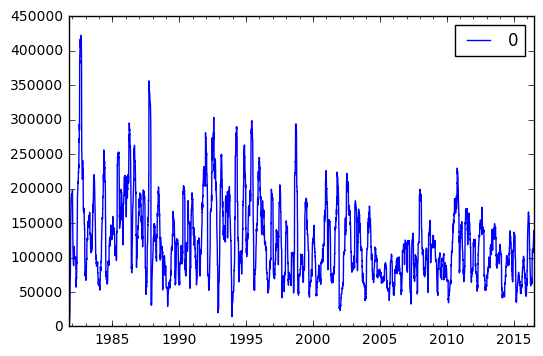

In [14]:
profits.rolling_ann_std().plot()

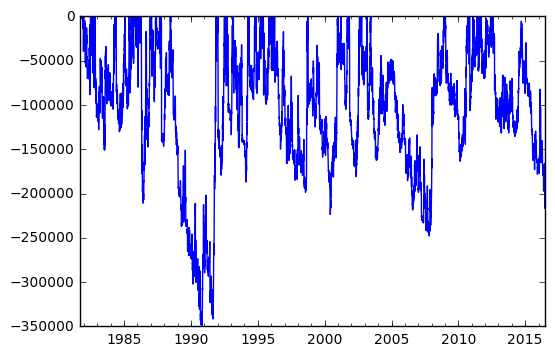

In [15]:
profits.drawdown().plot()

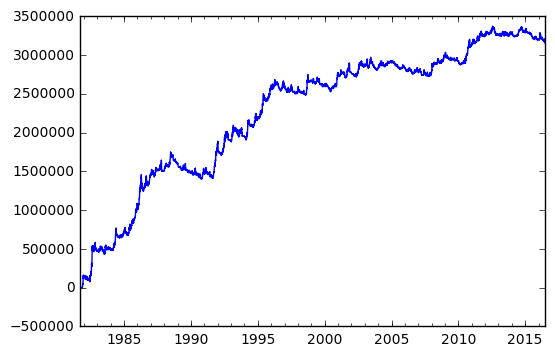

In [16]:
profits.curve().plot()